## 範例重點
* 學習如何在 keras 中加入 model checkpoint
* 知道如何設定監控目標
* 比較使用最佳與非最佳參數時的 performance

In [1]:
import os
import keras
import tensorflow as tf
# 本範例不需使用 GPU, 將 GPU 設定為 "無"
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = tf.keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [13]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [19]:
"""
# 載入 Callbacks, 並將監控目標設為 validation loss, 且只存最佳參數時的模型

參數說明：
filepath: 儲存模型的路徑與檔名
mointor: 以什麼指標作為判斷標準
save_best_only: 是否只要儲存最好的


"""
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                             monitor="val_loss",
                             save_weights_only=True, 
                             save_best_only=False)


#tf.keras.callbacks.ModelCheckpoint

keras.callbacks.ModelCheckpoint

In [24]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = tf.keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[model_ckpt]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

# Load back
from keras.models import load_model
#model.load_weights("./tmp.h5")
#model = tf.keras.models.load_model("tmp.h5")
#loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

pred_final = model.predict(x_test)

# Load back
model = keras.models.load_model("./tmp.h5")
pre_loadback = model.predict(x_test)
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
print(loss_loadback, acc_loadback)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization_30 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_31 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 hidden_layer3 (Dense)       (None, 128)               328

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10
49/49 [==============================] - 3s 24ms/step - loss: 2.1858 - accuracy: 0.2751 - val_loss: 2.1568 - val_accuracy: 0.1815
Epoch 2/10
49/49 [==============================] - 1s 16ms/step - loss: 1.7281 - accuracy: 0.3976 - val_loss: 1.9683 - val_accuracy: 0.2988
Epoch 3/10
49/49 [==============================] - 1s 16ms/step - loss: 1.6088 - accuracy: 0.4357 - val_loss: 1.8307 - val_accuracy: 0.3693
Epoch 4/10
49/49 [==============================] - 1s 17ms/step - loss: 1.5376 - accuracy: 0.4606 - val_loss: 1.7294 - val_accuracy: 0.3987
Epoch 5/10
49/49 [==============================] - 1s 16ms/step - loss: 1.4824 - accuracy: 0.4799 - val_loss: 1.6427 - val_accuracy: 0.4278
Epoch 6/10
49/49 [==============================] - 1s 16ms/step - loss: 1.4390 - accuracy: 0.4977 - val_loss: 1.5955 - val_accuracy: 0.4387
Epoch 7/10
49/49 [==============================] - 1s 17ms/step - loss: 1.3989 - accuracy: 0.5128 - val_loss: 1.5480 - val_accuracy: 0.4547
Epoch 8/10
49

ValueError: ignored

In [ ]:
pred_final = model.predict(x_test)

# Load back
model = keras.models.load_model("./tmp.h5")
pre_loadback = model.predict(x_test)
loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
print(loss_loadback, acc_loadback)

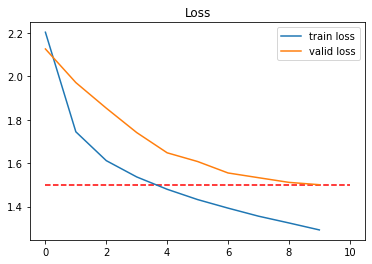

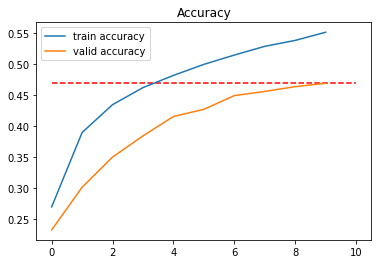

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

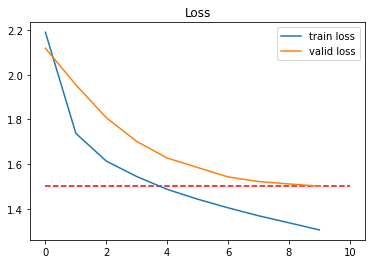

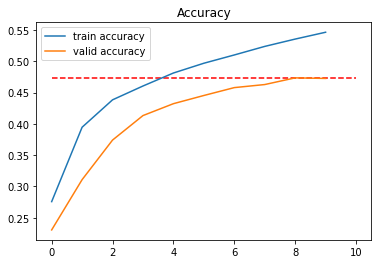

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.hlines(y=loss_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.hlines(y=acc_loadback, xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
plt.legend()
plt.title("Accuracy")
plt.show()

## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test